#### Imports

In [2]:
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 4.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import ParameterGrid
from skorch import NeuralNetRegressor
import skorch
from skorch.callbacks import EarlyStopping
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from tqdm import tqdm
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import csv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#### Data Management

In [4]:
def load_data(dataset="Xtrain"):
    mat = scipy.io.loadmat(dataset + ".mat")
    return mat[dataset]


def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    return normalized_data, mean, std


def denormalize_data(number, mean, std):
    return np.rint(number * std + mean).astype(np.int32)


def make_windows(series: np.ndarray, timesteps: int):
    w = np.lib.stride_tricks.sliding_window_view(series.squeeze(), timesteps + 1)
    X = w[:, :-1, None].astype(np.float32)
    y = w[:, -1, None].astype(np.float32)
    return X, y

#### Models (LR, FNN, GRU, CNN)

In [5]:
class LinearRegressorModule(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x: torch.Tensor):
        # Flatten if needed (batch_size, input_size)
        if x.ndim == 3:
            x = x.view(x.size(0), -1)
        return self.fc(x)

In [6]:
class FeedforwardRegressorModule(nn.Module):
    def __init__(self, input_size: int, hidden_sizes: tuple[int] = (64, 32), dropout: float = 0.0):
        super().__init__()
        layers = []
        in_features = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            in_features = hidden_size

        layers.append(nn.Linear(in_features, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        if x.ndim == 3:
            x = x.view(x.size(0), -1)
        return self.net(x)

In [7]:
class GRURegressorModule(nn.Module):
    def __init__(self, hidden_size: int = 32, num_layers: int = 1, dropout: float = 0.0):
        super().__init__()
        self.gru = nn.GRU(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor):
        _, h = self.gru(x)  # h: (num_layers, batch, hidden_size)
        return self.fc(h[-1])  # Use last GRU layer's hidden state

In [8]:
class ConvRegressorModule(nn.Module):
    def __init__(self, hidden_size: int = 32, kernel_size: int = 3, num_layers: int = 1, dropout: float = 0.0):
        super().__init__()
        layers = []
        in_channels = 1
        for _ in range(num_layers):
            layers.append(nn.Conv1d(in_channels, hidden_size, kernel_size, padding=kernel_size // 2))
            layers.append(nn.ReLU())
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            in_channels = hidden_size  # next layer's in_channels = hidden_size

        self.conv_block = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor):
        x = x.transpose(1, 2)  # (batch, features=1, timesteps)
        c = self.conv_block(x)
        p = self.pool(c).squeeze(-1)
        return self.fc(p)

#### Model Training and Hyperparameter Tuning

In [9]:
# models and their hyperparams
model_specs = {
    "LR": (
        LinearRegressorModule,
        {
        },
    ),
    "FNN": (
        FeedforwardRegressorModule,
        {
            "module__hidden_sizes": [(32,), (64, 32), (128, 64, 32)],
            "module__dropout": [0.0, 0.3, 0.4, 0.5],
            "optimizer__weight_decay": [0.0, 1e-4, 1e-3],  # L2 regularization
        },
    ),
    "GRU": (
        GRURegressorModule,
        {
            "module__hidden_size": [16, 32, 64],
            "module__num_layers": [1, 2],  # stacked GRUs
            "module__dropout": [0.0, 0.2],  # between GRU layers
            "optimizer__weight_decay": [0.0, 1e-4],
        },
    ),
    "Conv1D": (
        ConvRegressorModule,
        {
            "module__hidden_size": [16, 32, 64],
            "module__kernel_size": [3, 5],
            "module__num_layers": [1, 2],  # number of Conv blocks
            "module__dropout": [0.0, 0.2],
            "optimizer__weight_decay": [0.0, 1e-4],
        },
    ),
}

In [17]:
def find_best_model(data, device, cv_splits: int = 4, val_set_size: int = None,
                    model_name: str = None):
    timesteps_list = [5, 8, 10, 12, 14, 20, 30, 40, 50]
    learning_rates = [1e-3, 5e-4]

    tscv = TimeSeriesSplit(n_splits=cv_splits, test_size=val_set_size)
    best_mae = float("inf")
    best_cfg = {}
    best_model = None
    best_avg_mse = None

    selected_models = model_specs
    if model_name is not None:
        if model_name not in model_specs:
            raise ValueError(f"Model '{model_name}' not found in model_specs.")
        selected_models = {model_name: model_specs[model_name]}

    best_estimators_per_model = {}
    best_histories = {}

    for ts in tqdm(timesteps_list, desc="timesteps"):
        Xw, yw = make_windows(data, ts)

        for name, (ModuleClass, base_grid) in selected_models.items():
            full_grid = ParameterGrid({**base_grid, "optimizer__lr": learning_rates})

            for grid_params in full_grid:
                fold_maes = []
                full_history = []

                for fold, (train_idx, val_idx) in enumerate(tscv.split(Xw)):
                    X_train, X_val = Xw[train_idx], Xw[val_idx]
                    y_train, y_val = yw[train_idx], yw[val_idx]

                    module_kwargs = {"module__input_size": ts} if name in {"LR", "FNN"} else {}

                    net_params = {**module_kwargs, **grid_params}
                    net = NeuralNetRegressor(
                        ModuleClass,
                        **net_params,
                        criterion=nn.L1Loss,
                        optimizer=torch.optim.Adam,
                        max_epochs=100,
                        batch_size=64,
                        callbacks=[EarlyStopping(monitor="valid_loss", patience=10)],
                        train_split=skorch.dataset.ValidSplit(0.2),
                        device=device,
                        verbose=0,
                    )

                    net.fit(X_train, y_train)
                    y_pred = net.predict(X_val)
                    mae = mean_absolute_error(y_val, y_pred)
                    fold_maes.append(mae)

                    for epoch_data in net.history:
                        full_history.append([
                            name,
                            fold,
                            epoch_data['epoch'],
                            epoch_data.get('train_loss'),
                            epoch_data.get('valid_loss'),
                        ])

                avg_mae = np.mean(fold_maes)

                if avg_mae < best_mae:
                    best_mae = avg_mae
                    best_cfg = {"model": name, "timesteps": ts, **grid_params}
                    best_model = net

                    # Also calculate corresponding MSE for tracking
                    mse_scores = []
                    for _, val_idx in tscv.split(Xw):
                        y_val = yw[val_idx]
                        y_pred = best_model.predict(Xw[val_idx])
                        mse_scores.append(mean_squared_error(y_val, y_pred))
                    best_avg_mse = np.mean(mse_scores)

                if name not in best_estimators_per_model or avg_mae < best_estimators_per_model[name]["mae"]:
                    best_estimators_per_model[name] = {
                        "model": net,
                        "mae": avg_mae
                    }
                    best_histories[name] = full_history

    with open("loss.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["model", "fold", "epoch", "train_loss", "valid_loss"])
        for name, history in best_histories.items():
            writer.writerows(history)

    print("\nBest config:", best_cfg)
    print("Best MAE   :", best_mae)
    print("Best MSE   :", best_avg_mse)

    return best_model, best_cfg, best_mae, best_avg_mse

#### Evaluation

In [11]:
def denormalize_mae(mae, std):
    return mae * std  # mean gets cancelled when computing error


def denormalize_mse(mse, std):
    return mse * (std**2)

In [12]:
def predict(model, input_data, mean, std, nr_predictions=1):
    predictions = []
    input_data = np.array(input_data, dtype=np.float32)

    for _ in range(nr_predictions):
        model_input = torch.tensor(input_data.reshape(1, -1, 1), dtype=torch.float32)
        prediction = model.predict(model_input)
        next_val = prediction[0, 0]
        input_data = np.roll(input_data, -1)
        input_data[-1] = next_val
        predictions.append(denormalize_data(prediction[0], mean, std))

    return np.array(predictions)


In [13]:
def evaluate_predictions(y_true, y_pred):
    print("MAE on test set:", mean_absolute_error(y_true, y_pred))
    print("MSE on test set:", mean_squared_error(y_true, y_pred))

#### Plotting

In [14]:
def plot_data(ts_1, label_1, ts_2=None, label_2=None, title=None, scatter="True"):
    plt.figure(figsize=(10, 5))

    if scatter:
        plt.scatter(range(len(ts_1)), ts_1.ravel(), label=label_1, s=3, color="red")
        if ts_2 is not None:
            plt.scatter(range(len(ts_2)), ts_2.ravel(), label=label_2, s=3, marker='x')
    else:
        plt.plot(ts_1.ravel(), label=label_1)
        if ts_2 is not None:
            plt.plot(ts_2.ravel(), label=label_2, linestyle="--")

    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_loss_curves(csv_path="loss.csv"):
    df = pd.read_csv(csv_path)

    # Compute global min and max loss for consistent y-axis
    y_min = df[["train_loss", "valid_loss"]].min().min()
    y_max = df[["train_loss", "valid_loss"]].max().max()

    for model_name in df["model"].unique():
        model_df = df[df["model"] == model_name]

        # Average across folds
        grouped = model_df.groupby("epoch").agg({
            "train_loss": "mean",
            "valid_loss": "mean"
        }).reset_index()

        plt.figure()
        plt.plot(grouped["epoch"], grouped["train_loss"], label="Avg Train Loss")
        if not grouped["valid_loss"].isnull().all():
            plt.plot(grouped["epoch"], grouped["valid_loss"], label="Avg Valid Loss")
        plt.title(f"Loss Curve: {model_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (MAE)")
        plt.ylim(y_min, y_max)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

#### Run

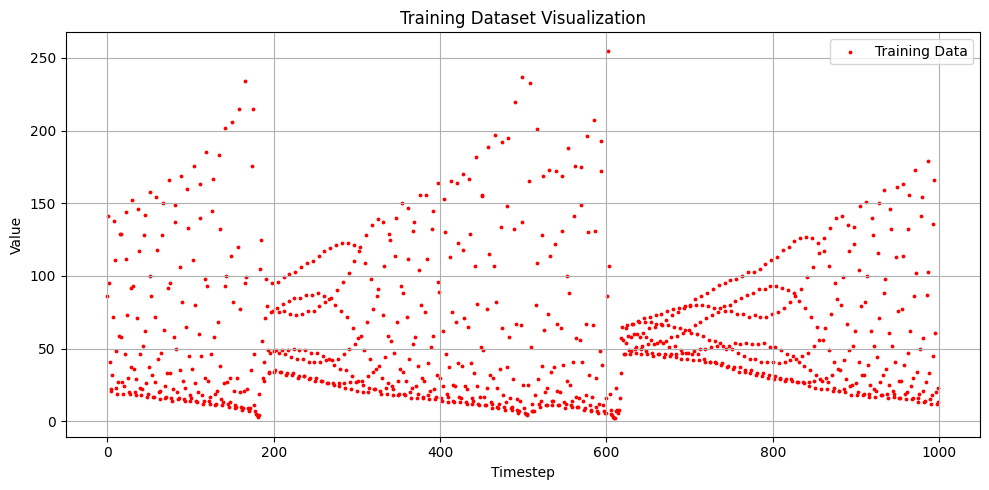

In [18]:
data_train = load_data()
plot_data(data_train, "Training Data", title="Training Dataset Visualization")
data_norm, mean, std = normalize_data(data_train)

In [19]:
model, cfg, mae, mse = find_best_model(data_norm, device, model_name=None, val_set_size=None)
print("Average MAE on validation sets denormalized:", denormalize_mae(mae, std))
print("Average MSE on validation sets denormalized:", denormalize_mse(mse, std))
predictions = predict(model, data_norm[-cfg["timesteps"]:], mean, std, nr_predictions=200)

timesteps: 100%|██████████| 1/1 [17:22<00:00, 1042.92s/it]


Best config: {'model': 'Conv1D', 'timesteps': 1, 'module__dropout': 0.0, 'module__hidden_size': 64, 'module__kernel_size': 5, 'module__num_layers': 2, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0}
Best MAE   : 0.5558172538876534
Best MSE   : 0.6410368531942368
Average MAE on validation sets denormalized: [26.04114322]
Average MSE on validation sets denormalized: [1407.14561449]


MAE on test set: 27.685
MSE on test set: 1719.895


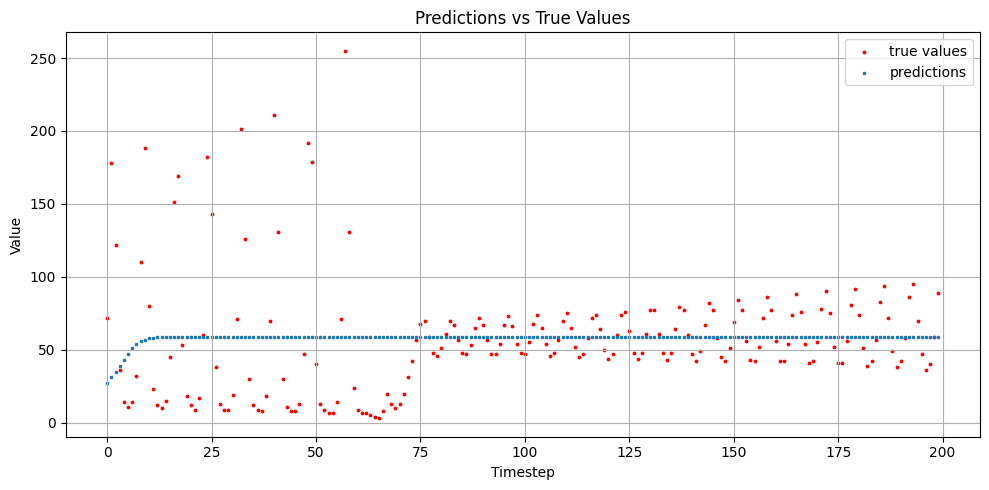

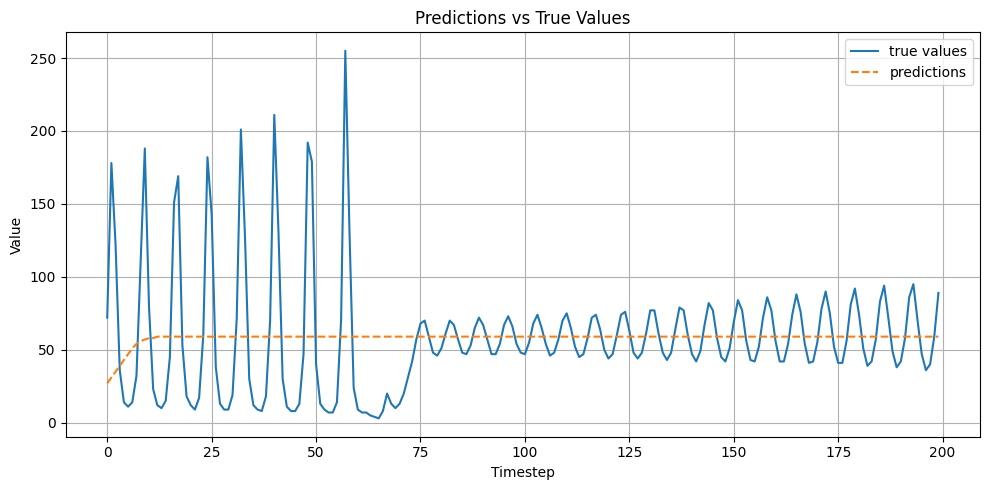

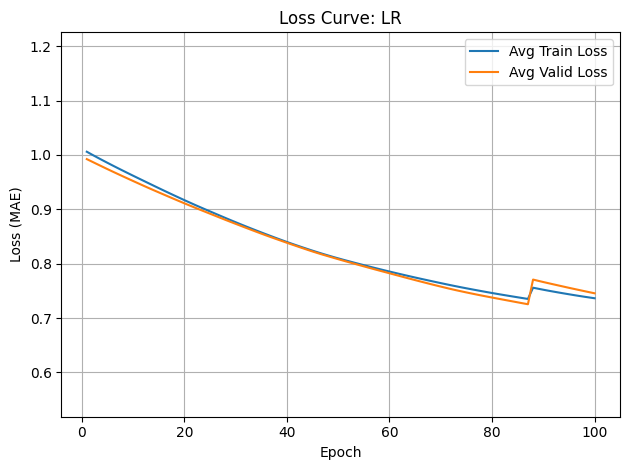

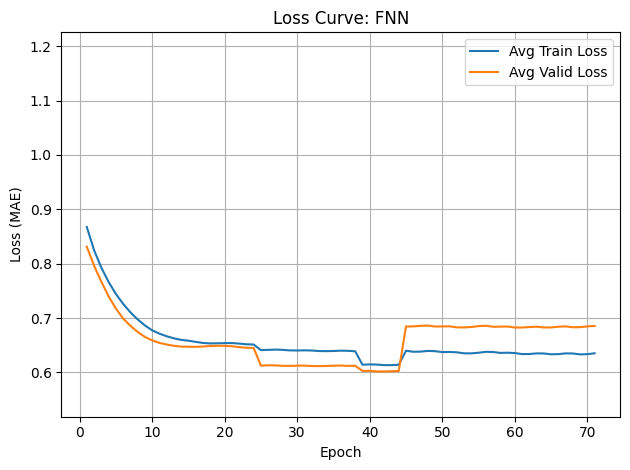

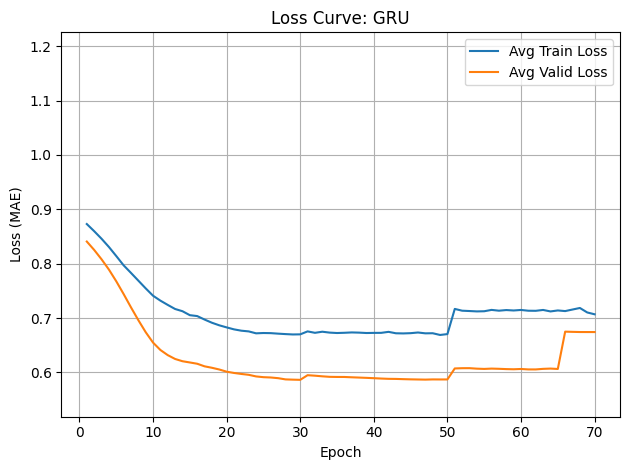

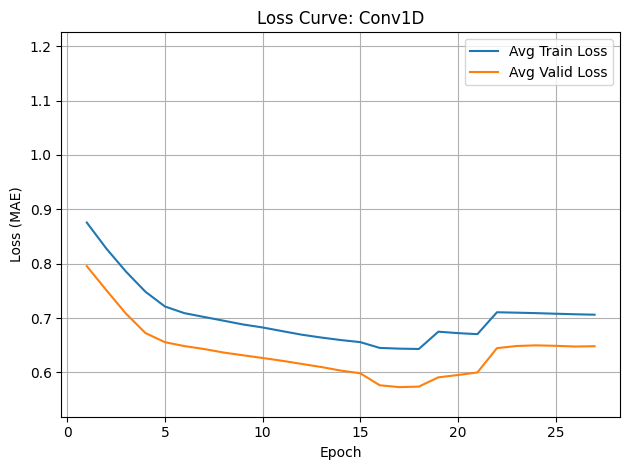

In [20]:
data_test = load_data("Xtest")
evaluate_predictions(data_test, predictions)
plot_data(data_test, "true values", predictions, "predictions", "Predictions vs True Values")
plot_data(data_test, "true values", predictions, "predictions", "Predictions vs True Values", False)
plot_loss_curves("loss.csv")